# Goal

* Identify branch lengths of taxonomic units to interpret TauD


# Init

In [1]:
import os
%load_ext rpy2.ipython

In [2]:
%%R
library(dplyr)
library(tidyr)
library(ggplot2)
library(ape)
library(reshape2)
library(phyloseq)

/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Need help getting started? Try the cookbook for R:
http://www.cookbook-r.com/Graphs/

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 
Attaching package: ‘reshape2’


  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-p

# Setting variables

In [34]:
%%R
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/consenTRAIT'

# 16S tree file of all representative OTU sequences
treeFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/fasttree/otusn_pick.tree'
Root = 'X90478'

# log2 fold change
l2fcResDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/'
l2fcResFile = file.path(l2fcResDir, 'Responders.txt')


# Testing trait depth on rhizosphere responders

### prune tree to OTUs in responder file

In [35]:
%%R 

tree = read.tree(treeFile)
tree


Phylogenetic tree with 11247 tips and 11245 internal nodes.

Tip labels:
	X90478, OTU.8116, OTU.6932, OTU.7640, OTU.6492, OTU.8138, ...
Node labels:
	, 0.970, 0.777, 0.682, 0.943, 0.847, ...

Unrooted; includes branch lengths.


In [36]:
%%R 
#Read responder table in order to prune trees
Resp = read.delim(l2fcResFile, sep='\t', header = FALSE)
head(Resp)

Resp$V1 = Resp$V1 %>% as.vector
rootrow = c(Root, rep(0, ncol(Resp)-1))
Resp = rbind(Resp, rootrow)

cat('Total number of OTUs:', Resp$V1 %>% unique %>% length, '\n\n')
Resp = Resp[,1]
Resp%>% tail(n=3)

Total number of OTUs: 4983 

[1] "OTU.9995" "OTU.9998" "X90478"  


In [37]:
%%R
Taxa = as.character(Resp)


In [38]:
%%R

pruneTree = function(tree, taxa, rootName){
    # not matching OTUs
    to.rm = setdiff(tree$tip, taxa)
    # pruning
    tree = drop.tip(tree, to.rm)    
    # rooting
    #tree = multi2di(tree)
    #tree = root(tree, rootName)
    # returning
    return(tree)
    }

tree.p = pruneTree(tree, taxa=Taxa)
#class(trees.p) = 'multiPhylo'

tree.p = root(tree.p, Root)
tree.p


Phylogenetic tree with 4983 tips and 4981 internal nodes.

Tip labels:
	X90478, OTU.4087, OTU.2009, OTU.5899, OTU.4181, OTU.3052, ...
Node labels:
	, 0.769, 0.872.32, 0.797.22, 0.788.6, 0.796.4, ...

Unrooted; includes branch lengths.


In [40]:
%%R
tree.p = root(tree.p, 4983)
tree.p
#tree.p$tip.label


Phylogenetic tree with 4983 tips and 4981 internal nodes.

Tip labels:
	X90478, OTU.4087, OTU.2009, OTU.5899, OTU.4181, OTU.3052, ...
Node labels:
	0.895.38, , 0.769, 0.872.32, 0.797.22, 0.788.6, ...

Unrooted; includes branch lengths.


In [41]:
%%R
# Calculate branch depths
bD = cophenetic.phylo(tree.p)


In [42]:
%%R
bD[ lower.tri( bD, diag = TRUE ) ]  <- NA
bD.m = melt(bD, na.rm = TRUE)
bD.m %>% head

          Var1     Var2   value
4984    X90478 OTU.4087 0.77239
9967    X90478 OTU.2009 0.78119
9968  OTU.4087 OTU.2009 0.04474
14950   X90478 OTU.5899 0.65848
14951 OTU.4087 OTU.5899 0.37839
14952 OTU.2009 OTU.5899 0.38719


## Get taxonomic info from phyloseq object

In [43]:
%%R
#Read rarified phyloseq object
F = file.path('/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3_r')
physeq.Full = readRDS(F)
physeq.Full

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 238 samples ]
sample_data() Sample Data:       [ 238 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


In [44]:
%%R
Names = tax_table(physeq.Full) %>% as.data.frame()
physeq.Full = NULL
head(Names)

            Rank1         Rank2                Rank3                     Rank4
OTU.4087 Bacteria           TM6 uncultured_bacterium                      <NA>
OTU.2009 Bacteria           TM6 uncultured_bacterium                      <NA>
OTU.5899 Bacteria Acidobacteria                32-21      uncultured_bacterium
OTU.4181 Bacteria Elusimicrobia          Lineage_IIa      uncultured_bacterium
OTU.3052 Bacteria Elusimicrobia          Lineage_IIa uncultured_soil_bacterium
OTU.1890 Bacteria Elusimicrobia          Lineage_IIb      uncultured_bacterium
         Rank5 Rank6 Rank7 Rank8
OTU.4087  <NA>  <NA>  <NA>  <NA>
OTU.2009  <NA>  <NA>  <NA>  <NA>
OTU.5899  <NA>  <NA>  <NA>  <NA>
OTU.4181  <NA>  <NA>  <NA>  <NA>
OTU.3052  <NA>  <NA>  <NA>  <NA>
OTU.1890  <NA>  <NA>  <NA>  <NA>


In [45]:
%%R
Names$OTU = rownames(Names)
Names.x = Names
colnames(Names.x)[1:8] = paste(colnames(Names.x)[1:8],"x", sep = ".")
Names.y = Names
colnames(Names.y)[1:8] = paste(colnames(Names.y)[1:8],"y", sep = ".")
head(Names.y)


          Rank1.y       Rank2.y              Rank3.y                   Rank4.y
OTU.4087 Bacteria           TM6 uncultured_bacterium                      <NA>
OTU.2009 Bacteria           TM6 uncultured_bacterium                      <NA>
OTU.5899 Bacteria Acidobacteria                32-21      uncultured_bacterium
OTU.4181 Bacteria Elusimicrobia          Lineage_IIa      uncultured_bacterium
OTU.3052 Bacteria Elusimicrobia          Lineage_IIa uncultured_soil_bacterium
OTU.1890 Bacteria Elusimicrobia          Lineage_IIb      uncultured_bacterium
         Rank5.y Rank6.y Rank7.y Rank8.y      OTU
OTU.4087    <NA>    <NA>    <NA>    <NA> OTU.4087
OTU.2009    <NA>    <NA>    <NA>    <NA> OTU.2009
OTU.5899    <NA>    <NA>    <NA>    <NA> OTU.5899
OTU.4181    <NA>    <NA>    <NA>    <NA> OTU.4181
OTU.3052    <NA>    <NA>    <NA>    <NA> OTU.3052
OTU.1890    <NA>    <NA>    <NA>    <NA> OTU.1890


## Join taxonomy with distance matrix

In [46]:
%%R
head(bD.m)

          Var1     Var2   value
4984    X90478 OTU.4087 0.77239
9967    X90478 OTU.2009 0.78119
9968  OTU.4087 OTU.2009 0.04474
14950   X90478 OTU.5899 0.65848
14951 OTU.4087 OTU.5899 0.37839
14952 OTU.2009 OTU.5899 0.38719


In [47]:
%%R
Dist = left_join(bD.m, Names.x, by = c("Var1" = "OTU"))
head(Dist)

      Var1     Var2   value  Rank1.x Rank2.x              Rank3.x Rank4.x
1   X90478 OTU.4087 0.77239     <NA>    <NA>                 <NA>    <NA>
2   X90478 OTU.2009 0.78119     <NA>    <NA>                 <NA>    <NA>
3 OTU.4087 OTU.2009 0.04474 Bacteria     TM6 uncultured_bacterium    <NA>
4   X90478 OTU.5899 0.65848     <NA>    <NA>                 <NA>    <NA>
5 OTU.4087 OTU.5899 0.37839 Bacteria     TM6 uncultured_bacterium    <NA>
6 OTU.2009 OTU.5899 0.38719 Bacteria     TM6 uncultured_bacterium    <NA>
  Rank5.x Rank6.x Rank7.x Rank8.x
1    <NA>    <NA>    <NA>    <NA>
2    <NA>    <NA>    <NA>    <NA>
3    <NA>    <NA>    <NA>    <NA>
4    <NA>    <NA>    <NA>    <NA>
5    <NA>    <NA>    <NA>    <NA>
6    <NA>    <NA>    <NA>    <NA>


In [48]:
%%R
Dist = left_join(Dist, Names.y, by = c("Var2" = "OTU"))
head(Dist)

      Var1     Var2   value  Rank1.x Rank2.x              Rank3.x Rank4.x
1   X90478 OTU.4087 0.77239     <NA>    <NA>                 <NA>    <NA>
2   X90478 OTU.2009 0.78119     <NA>    <NA>                 <NA>    <NA>
3 OTU.4087 OTU.2009 0.04474 Bacteria     TM6 uncultured_bacterium    <NA>
4   X90478 OTU.5899 0.65848     <NA>    <NA>                 <NA>    <NA>
5 OTU.4087 OTU.5899 0.37839 Bacteria     TM6 uncultured_bacterium    <NA>
6 OTU.2009 OTU.5899 0.38719 Bacteria     TM6 uncultured_bacterium    <NA>
  Rank5.x Rank6.x Rank7.x Rank8.x  Rank1.y       Rank2.y              Rank3.y
1    <NA>    <NA>    <NA>    <NA> Bacteria           TM6 uncultured_bacterium
2    <NA>    <NA>    <NA>    <NA> Bacteria           TM6 uncultured_bacterium
3    <NA>    <NA>    <NA>    <NA> Bacteria           TM6 uncultured_bacterium
4    <NA>    <NA>    <NA>    <NA> Bacteria Acidobacteria                32-21
5    <NA>    <NA>    <NA>    <NA> Bacteria Acidobacteria                32-21
6    <NA>    <

# Calculate average branching depths of various taxonomic levels


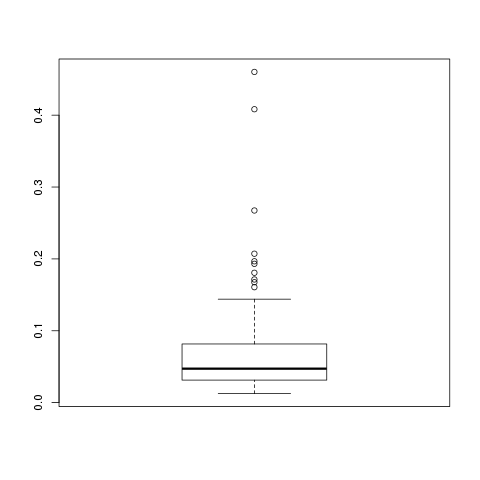

In [54]:
%%R
Dist %>% 
    filter(Rank6.x == Rank6.y & !is.na(Rank6.x)) %>%
    group_by(Rank6.x) %>%
    summarize(mean_br_len = mean(value)/2) %>%
    ungroup() %>% 
    arrange(desc(mean_br_len)) %>%
    .$mean_br_len %>%
    boxplot()

# Calling concenTRAIT - Nick's old version

In [ ]:
treeFile = "/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/consenTRAIT/otusn_pick_3in3.nwk"
respFileDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/consenTRAIT/'
respFile = os.path.join(respFileDir, 'Responders_wRoot.txt')

In [ ]:
!/home/bryan/tree_edit/bin/concentrait.r -p 20 \
    $treeFile $rootName $respFile > RhizResponders_tauD.txt

Trait	  tau_D			p-value 
t1	0.020504968504344	0.04 

# Calling consenTRAIT - Nick's new version

In [ ]:
!Rscript /home/bryan/consenTRAIT/consenTRAIT.r -p 20 \
    $treeFile $rootName $respFile > RhizResponders_tauD.txt

In [ ]:
%%R
df.CT.sub = read.delim('RhizResponders_tauD.txt', sep='\t', header = FALSE)
head(df.CT.sub)
# #
# df.CT.sub = read.delim('incorp_trait_bySub_tauD.txt', sep='\t')
# df.CT.sub$Substrate = df.l2fc$Substrate %>% levels


# p.cut = function(p){
#     if(p < 0.01){
#         return('<0.01')
#     } else
#     if(p < 0.05){
#         return('<0.05')
#     } else{
#         return('>0.05')
#     }
# }

# df.CT.sub = df.CT.sub  %>%
#     mutate(p.value.id = sapply(p.value, p.cut))

# df.CT.sub 

# Check test to make sure it is working well

In [ ]:
#Making example files with 100 taxa and 2 traits: the 1st trait is conserved and the 2nd is not.

!Rscript /home/bryan/consenTRAIT/consenTRAIT.r -x 100 TEST TEST TEST



In [ ]:
#Running consenTRAIT with bootstrapping in parallel (4 cores)

!Rscript /home/bryan/consenTRAIT/consenTRAIT.r -p 4 consentrait_TEST.nwk t1 consentrait_TEST.txt